In [1]:
import torch
print("PyTorch Version : {}".format(torch.__version__))
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm
import numpy as np
np.random.seed(112)
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

PyTorch Version : 1.11.0


In [2]:
## Import and preprocess (dataset) data, and batch it (dataloader)

In [3]:
datapath = 'BBC_News_Train.csv'
df = pd.read_csv(datapath)
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
df['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

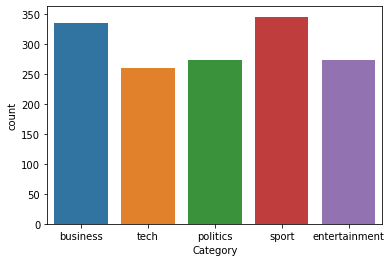

In [5]:
import seaborn as sns
ax = sns.countplot(x="Category",data=df)

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [7]:
print('Train size:{}, Test size:{}'.format(len(df_train), len(df_test)))

Train size:1192, Test size:298


In [8]:
from transformers import BertTokenizer

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [10]:
labels = {'business':0,
          'entertainment':1,
          'politics':2,
          'sport':3,
          'tech':4          
          }

In [11]:
class DataGen(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Category']]
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, 
                                truncation=True, return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [12]:
## Model building

In [22]:
class Model(nn.Module):

    def __init__(self, dropout=0.5):

        super(Model, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.linear_layer = nn.Linear(768, 5)
        self.dropout_layer = nn.Dropout(dropout)
        self.relu_actfn = nn.ReLU()

    def forward(self, input_id, mask):

        _, x = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x = self.dropout_layer(x)
        x = self.linear_layer(x)
        output = self.relu_actfn(x)

        return output

In [23]:
## Training loop

In [28]:
def train(model, train_data, val_data, learning_rate, epochs, cv=0):

    train, val = DataGen(train_data), DataGen(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
        model = model.cuda()
        loss_fn = loss_fn.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = loss_fn(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = loss_fn(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
    torch.save(model, 'model-{}.pth'.format(cv))
            
    return (total_acc_val / len(val_data))
                  

In [29]:
EPOCHS = 10
LR = 1e-6

val_losses = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
k=1
for train_indx, test_indx in kfold.split(df):
    model = Model()
    df_train = df.iloc[train_indx]
    df_val = df.iloc[test_indx]
    val_losses.append(train(model, df_train, df_val, LR, EPOCHS, k))
    k+=1

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.55it/s]


Epochs: 1 | Train Loss:  0.779                 | Train Accuracy:  0.310                 | Val Loss:  0.707                 | Val Accuracy:  0.470


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.37it/s]


Epochs: 2 | Train Loss:  0.545                 | Train Accuracy:  0.687                 | Val Loss:  0.364                 | Val Accuracy:  0.903


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.35it/s]


Epochs: 3 | Train Loss:  0.261                 | Train Accuracy:  0.944                 | Val Loss:  0.187                 | Val Accuracy:  0.966


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.34it/s]


Epochs: 4 | Train Loss:  0.144                 | Train Accuracy:  0.977                 | Val Loss:  0.118                 | Val Accuracy:  0.977


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.29it/s]


Epochs: 5 | Train Loss:  0.085                 | Train Accuracy:  0.990                 | Val Loss:  0.092                 | Val Accuracy:  0.970


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.33it/s]


Epochs: 6 | Train Loss:  0.056                 | Train Accuracy:  0.994                 | Val Loss:  0.062                 | Val Accuracy:  0.990


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.33it/s]


Epochs: 7 | Train Loss:  0.038                 | Train Accuracy:  0.996                 | Val Loss:  0.051                 | Val Accuracy:  0.987


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.34it/s]


Epochs: 8 | Train Loss:  0.026                 | Train Accuracy:  0.998                 | Val Loss:  0.042                 | Val Accuracy:  0.987


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.33it/s]


Epochs: 9 | Train Loss:  0.019                 | Train Accuracy:  0.998                 | Val Loss:  0.039                 | Val Accuracy:  0.987


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.27it/s]


Epochs: 10 | Train Loss:  0.014                 | Train Accuracy:  0.999                 | Val Loss:  0.034                 | Val Accuracy:  0.987


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.29it/s]


Epochs: 1 | Train Loss:  0.799                 | Train Accuracy:  0.267                 | Val Loss:  0.776                 | Val Accuracy:  0.332


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.29it/s]


Epochs: 2 | Train Loss:  0.687                 | Train Accuracy:  0.492                 | Val Loss:  0.599                 | Val Accuracy:  0.567


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.31it/s]


Epochs: 3 | Train Loss:  0.463                 | Train Accuracy:  0.734                 | Val Loss:  0.376                 | Val Accuracy:  0.779


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.32it/s]


Epochs: 4 | Train Loss:  0.296                 | Train Accuracy:  0.836                 | Val Loss:  0.240                 | Val Accuracy:  0.896


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.32it/s]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.956                 | Val Loss:  0.141                 | Val Accuracy:  0.977


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.33it/s]


Epochs: 6 | Train Loss:  0.100                 | Train Accuracy:  0.988                 | Val Loss:  0.095                 | Val Accuracy:  0.973


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.32it/s]


Epochs: 7 | Train Loss:  0.063                 | Train Accuracy:  0.992                 | Val Loss:  0.079                 | Val Accuracy:  0.980


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.33it/s]


Epochs: 8 | Train Loss:  0.041                 | Train Accuracy:  1.000                 | Val Loss:  0.066                 | Val Accuracy:  0.977


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.32it/s]


Epochs: 9 | Train Loss:  0.029                 | Train Accuracy:  0.999                 | Val Loss:  0.058                 | Val Accuracy:  0.977


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.31it/s]


Epochs: 10 | Train Loss:  0.020                 | Train Accuracy:  1.000                 | Val Loss:  0.052                 | Val Accuracy:  0.980


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.35it/s]


Epochs: 1 | Train Loss:  0.752                 | Train Accuracy:  0.345                 | Val Loss:  0.708                 | Val Accuracy:  0.409


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.34it/s]


Epochs: 2 | Train Loss:  0.602                 | Train Accuracy:  0.592                 | Val Loss:  0.510                 | Val Accuracy:  0.681


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.43it/s]


Epochs: 3 | Train Loss:  0.400                 | Train Accuracy:  0.802                 | Val Loss:  0.366                 | Val Accuracy:  0.836


100%|█████████████████████████████████████████| 596/596 [00:31<00:00, 19.20it/s]


Epochs: 4 | Train Loss:  0.289                 | Train Accuracy:  0.888                 | Val Loss:  0.265                 | Val Accuracy:  0.906


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.29it/s]


Epochs: 5 | Train Loss:  0.206                 | Train Accuracy:  0.937                 | Val Loss:  0.211                 | Val Accuracy:  0.919


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.44it/s]


Epochs: 6 | Train Loss:  0.145                 | Train Accuracy:  0.968                 | Val Loss:  0.161                 | Val Accuracy:  0.940


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.42it/s]


Epochs: 7 | Train Loss:  0.111                 | Train Accuracy:  0.986                 | Val Loss:  0.135                 | Val Accuracy:  0.963


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.41it/s]


Epochs: 8 | Train Loss:  0.083                 | Train Accuracy:  0.992                 | Val Loss:  0.097                 | Val Accuracy:  0.963


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.42it/s]


Epochs: 9 | Train Loss:  0.052                 | Train Accuracy:  0.996                 | Val Loss:  0.087                 | Val Accuracy:  0.960


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.42it/s]


Epochs: 10 | Train Loss:  0.040                 | Train Accuracy:  0.996                 | Val Loss:  0.077                 | Val Accuracy:  0.956


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.31it/s]


Epochs: 1 | Train Loss:  0.789                 | Train Accuracy:  0.271                 | Val Loss:  0.715                 | Val Accuracy:  0.460


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.34it/s]


Epochs: 2 | Train Loss:  0.486                 | Train Accuracy:  0.784                 | Val Loss:  0.322                 | Val Accuracy:  0.899


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.30it/s]


Epochs: 3 | Train Loss:  0.236                 | Train Accuracy:  0.963                 | Val Loss:  0.191                 | Val Accuracy:  0.946


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.41it/s]


Epochs: 4 | Train Loss:  0.136                 | Train Accuracy:  0.979                 | Val Loss:  0.132                 | Val Accuracy:  0.953


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.27it/s]


Epochs: 5 | Train Loss:  0.087                 | Train Accuracy:  0.991                 | Val Loss:  0.093                 | Val Accuracy:  0.966


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.29it/s]


Epochs: 6 | Train Loss:  0.059                 | Train Accuracy:  0.992                 | Val Loss:  0.084                 | Val Accuracy:  0.966


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.30it/s]


Epochs: 7 | Train Loss:  0.039                 | Train Accuracy:  0.998                 | Val Loss:  0.061                 | Val Accuracy:  0.970


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.28it/s]


Epochs: 8 | Train Loss:  0.028                 | Train Accuracy:  0.998                 | Val Loss:  0.067                 | Val Accuracy:  0.963


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.31it/s]


Epochs: 9 | Train Loss:  0.019                 | Train Accuracy:  1.000                 | Val Loss:  0.057                 | Val Accuracy:  0.966


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.30it/s]


Epochs: 10 | Train Loss:  0.014                 | Train Accuracy:  1.000                 | Val Loss:  0.053                 | Val Accuracy:  0.963


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.35it/s]


Epochs: 1 | Train Loss:  0.788                 | Train Accuracy:  0.289                 | Val Loss:  0.753                 | Val Accuracy:  0.342


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.32it/s]


Epochs: 2 | Train Loss:  0.585                 | Train Accuracy:  0.634                 | Val Loss:  0.435                 | Val Accuracy:  0.792


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.31it/s]


Epochs: 3 | Train Loss:  0.282                 | Train Accuracy:  0.935                 | Val Loss:  0.221                 | Val Accuracy:  0.936


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.29it/s]


Epochs: 4 | Train Loss:  0.150                 | Train Accuracy:  0.976                 | Val Loss:  0.156                 | Val Accuracy:  0.956


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.30it/s]


Epochs: 5 | Train Loss:  0.089                 | Train Accuracy:  0.993                 | Val Loss:  0.113                 | Val Accuracy:  0.963


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.30it/s]


Epochs: 6 | Train Loss:  0.062                 | Train Accuracy:  0.995                 | Val Loss:  0.096                 | Val Accuracy:  0.963


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.28it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.996                 | Val Loss:  0.089                 | Val Accuracy:  0.966


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.27it/s]


Epochs: 8 | Train Loss:  0.030                 | Train Accuracy:  0.999                 | Val Loss:  0.074                 | Val Accuracy:  0.973


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.27it/s]


Epochs: 9 | Train Loss:  0.022                 | Train Accuracy:  0.999                 | Val Loss:  0.077                 | Val Accuracy:  0.970


100%|█████████████████████████████████████████| 596/596 [00:30<00:00, 19.26it/s]


Epochs: 10 | Train Loss:  0.017                 | Train Accuracy:  0.999                 | Val Loss:  0.073                 | Val Accuracy:  0.973


In [ ]:
## CV model performance

In [50]:
mean_cv_acc = round(np.mean(val_losses), 3)
std_cv_acc = round(np.std(val_losses), 3)

In [51]:
print('Mean CV Accuracy: {}, SD CV Accuracy: {}'.format(mean_cv_acc, std_cv_acc))

Mean CV Accuracy: 0.972, SD CV Accuracy: 0.011


In [52]:
# Evaluate Model on Test Data

In [53]:
def predict(model, test_data):
    
    Y_actual = []
    Y_preds = []
    test = DataGen(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            
            Y_actual.append(test_label[0].item())
            Y_actual.append(test_label[1].item())
            
            Y_preds.append(output.argmax(dim=1)[0].item())
            Y_preds.append(output.argmax(dim=1)[1].item())
            

              #acc = (output.argmax(dim=1) == test_label).sum().item()
              #total_acc_test += acc
    
    #print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return Y_actual, Y_preds

In [54]:
Y_actual, Y_preds = predict(model, df_test)

In [55]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

target_classes = ["business", "entertainment", "politics", "sport", "tech"]

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9899328859060402

Classification Report : 
               precision    recall  f1-score   support

     business       0.99      0.97      0.98        71
entertainment       1.00      1.00      1.00        66
     politics       0.96      0.98      0.97        51
        sport       1.00      1.00      1.00        60
         tech       1.00      1.00      1.00        50

     accuracy                           0.99       298
    macro avg       0.99      0.99      0.99       298
 weighted avg       0.99      0.99      0.99       298


Confusion Matrix : 
[[69  0  2  0  0]
 [ 0 66  0  0  0]
 [ 1  0 50  0  0]
 [ 0  0  0 60  0]
 [ 0  0  0  0 50]]
